# Y2Q1 Data Access

This is a notebook to document data access for the Year 2 Quick Release (Y2Q1) catalog. More details on Y2Q1 can be found on the DES internal confluence page [here](https://opensource.ncsa.illinois.edu/confluence/display/DESDM/Y2Q1+Release+Notes).

In [1]:
%matplotlib inline

In [2]:
import easyaccess as ea
import numpy as np
import pylab as plt

#### Connect to the DESDM DB

In [3]:
conn = ea.connect(section='dessci',quiet=True)

#### Quick investigation of the Y2Q1 objects table

In [4]:
query = "select count(*) from Y2Q1_OBJECTS;"
conn.onecmd(query)



1 rows in 0.67 seconds

    COUNT(*)
1  159565956



#### Spatial selection around the globular cluster M2

To demonstrate a few simple queries, we examine the globular cluster [Messier 2 (NGC 7089)](https://ned.ipac.caltech.edu/cgi-bin/objsearch?objname=m2&extend=no&hconst=73&omegam=0.27&omegav=0.73&corr_z=1&out_csys=Equatorial&out_equinox=J2000.0&obj_sort=RA+or+Longitude&of=pre_text&zv_breaker=30000.0&list_limit=5&img_stamp=YES).

In [5]:
query = """
--- Select stars near Messier 2
--- (ra,dec) = (323.36,-0.82)
--- We use a conventional set of 'BETWEEN' statements
--- based on RA and DEC.           
select QUICK_OBJECT_ID, RA, DEC, HPX2048,
WAVG_MAG_PSF_G, WAVG_MAG_PSF_R, WAVG_SPREAD_MODEL_R
from Y2Q1_OBJECTS
where RA between 323.36 - 0.20 and 323.36 + 0.20
and DEC between -0.82 - 0.20 and -0.82 + 0.20
and WAVG_MAG_PSF_G between 10 and 30
and WAVG_MAG_PSF_R between 10 and 30
and abs(WAVG_SPREAD_MODEL_R) < 0.002
"""
data = conn.query_to_pandas(query).to_records()

(23.179600000000001, 15.5357)

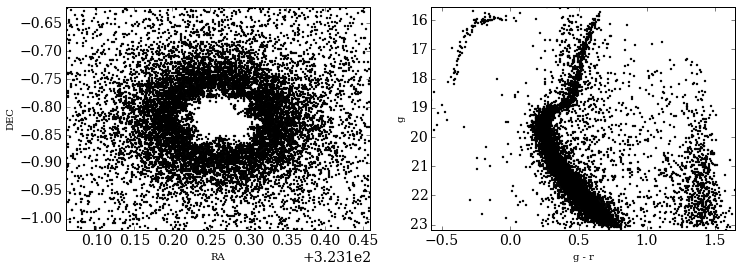

In [6]:
fig,ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(data['RA'],data['DEC'],s=2,c='k')
ax[0].set_xlabel('RA'); ax[0].set_ylabel('DEC')
ax[0].set_xlim(min(data['RA']),max(data['RA'])) 
ax[0].set_ylim(min(data['DEC']),max(data['DEC']))
color = data['WAVG_MAG_PSF_G']-data['WAVG_MAG_PSF_R']; mag = data['WAVG_MAG_PSF_G']
ax[1].scatter(color,mag,s=2,c='k')
ax[1].set_xlabel('g - r'); ax[1].set_ylabel('g')
ax[1].set_xlim(min(color),max(color)); ax[1].set_ylim(max(mag),min(mag))

#### HEALPix selection of M2

The Y2Q1_OBJECT table also contains an NSIDE=2048 (area ~ $8 \times 10^{-4}$ deg$^2$) ***nested*** HEALPix index for each catalog object. These indices can be used to quickly access objects within a given region of the sky. This is done by first finding the HEALPix index of your target at the preferred resolution, and then converting to NSIDE=2048. (The healpy toolkit has several useful utilities for this conversion.) I've designed such a query for Messier 2 as an example:

In [7]:
query = """
--- Query to select Messier 2 stars using HEALPix index
--- (ra,dec) = (323.36,-0.82)
--- Using healpy.ang2pix with nside=128, this is pixel 76364
--- with a nside conversion factor of 256 between 128 and 2048.
--- To select all objects in pixel 76364, we want all objects
--- with HPX2048 between PIXEL*FACTOR and (PIXEL+1)*FACTOR
select QUICK_OBJECT_ID, RA, DEC, HPX2048,
WAVG_MAG_PSF_G, WAVG_MAG_PSF_R, WAVG_SPREAD_MODEL_R
from Y2Q1_OBJECTS
where HPX2048 > (76364)*256 and HPX2048 < (76364 + 1)*256
and WAVG_MAG_PSF_G between 10 and 30
and WAVG_MAG_PSF_R between 10 and 30
and abs(WAVG_SPREAD_MODEL_R) < 0.002
"""
data  = conn.query_to_pandas(query).to_records()

(23.212, 15.430300000000001)

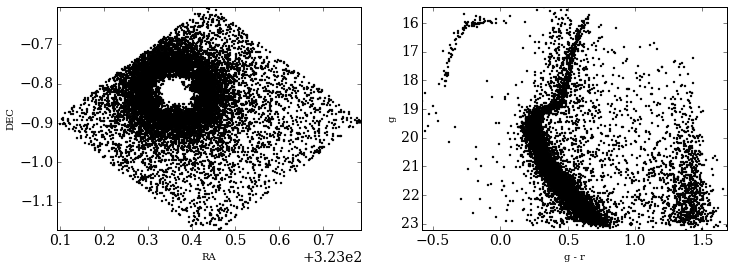

In [8]:
fig,ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(data['RA'],data['DEC'],s=2,c='k')
ax[0].set_xlabel('RA'); ax[0].set_ylabel('DEC')
ax[0].set_xlim(min(data['RA']),max(data['RA'])) 
ax[0].set_ylim(min(data['DEC']),max(data['DEC']))
color = data['WAVG_MAG_PSF_G']-data['WAVG_MAG_PSF_R']; mag = data['WAVG_MAG_PSF_G']
ax[1].scatter(color,mag,s=2,c='k')
ax[1].set_xlabel('g - r'); ax[1].set_ylabel('g')
ax[1].set_xlim(min(color),max(color)); ax[1].set_ylim(max(mag),min(mag))

#### Single epoch object IDs

To match between unique objects in Y2Q1_OBJECTS and the individual single-epoch observations that compose them, use the Y2Q1_OBJECTS_INDEX table. This table is a bit complicated because it merges the Y2N FIRSTCUT object catalogs (PROD.SE_OBJECTS) with the Y1A1 FINALCUT object catalog (Y1A1_OBJECTS). The unique identifier for Y2N objects is the combination of FILENAME and OBJECT_NUMBER, while for Y1A1, the OBJECT_NUMBER field alone is enough (this is a mapping to Y1A1_OBJECTS.OBJECT_ID).

Below, we play around with grabbing the single-epoch identifier for stars in the horizontal branch (15 > g > 18 and -0.5 < g-r < 0.0) of M2. For example, this could be a useful step in an analysis looking for variable stars (e.g. RR Lyrae) in M2.

In [9]:
query = """

--- Grab single-epoch observations of objects in the unique catalog
--- This is far from perfect, but should suffice as a first pass...
select QUICK_OBJECT_ID, FILENAME, OBJECT_NUMBER 
from Y2Q1_OBJECTS_INDEX where QUICK_OBJECT_ID in 
(select QUICK_OBJECT_ID 
from Y2Q1_OBJECTS where HPX2048 > (76364)*256 and HPX2048 < (76364 + 1)*256 
and WAVG_MAG_PSF_G between 15 and 18 and WAVG_MAG_PSF_G-WAVG_MAG_PSF_R between -0.5 and 0.0 
and abs(WAVG_SPREAD_MODEL_R) < 0.002) 
and rownum < 10
"""
conn.query_and_print(query)



9 rows in 2.81 seconds

   QUICK_OBJECT_ID                                          FILENAME  OBJECT_NUMBER
1   10156100057612  D00232749_c29_fake.fits                             24601049381
2   10156100057612  D00237968_c29_fake.fits                             24654949975
3   10156100164554  D00231817_c54_fake.fits                             24758359022
4   10156100164230  D00232341_c9_fake.fits                              24589429302
5   10156100164554  D00237663_c40_fake.fits                             24646168264
6   10156100164554  D00239270_c40_fake.fits                             24667798406
7   10156100164554  D00233015_c40_fake.fits                             24603385685
8   10156100164554  D00243436_c40_fake.fits                             24740254596
9   10156100164230  D00232233_c9_fake.fits                              24590771390



Things become easier if you are interested in just a single object

In [10]:
query = """
--- Grab single-epoch observations of objects in the unique catalog
--- This is far from perfect, but should suffice as a first pass...
select QUICK_OBJECT_ID, FILENAME, OBJECT_NUMBER 
from Y2Q1_OBJECTS_INDEX where QUICK_OBJECT_ID = 10288800210672
"""
conn.query_and_print(query)



12 rows in 0.08 seconds

    QUICK_OBJECT_ID                                          FILENAME  OBJECT_NUMBER
1    10288800210672  D00369715_z_c09_r1113p01_red-fullcat.fits                   327
2    10288800210672  D00363770_Y_c53_r1064p01_red-fullcat.fits                     2
3    10288800210672  D00354942_i_c09_r988p01_red-fullcat.fits                    147
4    10288800210672  D00369713_r_c53_r1113p01_red-fullcat.fits                     5
5    10288800210672  D00363768_z_c29_r1064p01_red-fullcat.fits                  1345
6    10288800210672  D00369733_i_c29_r1113p01_red-fullcat.fits                  1410
7    10288800210672  D00369714_g_c53_r1113p01_red-fullcat.fits                     4
8    10288800210672  D00363767_r_c29_r1064p01_red-fullcat.fits                  1452
9    10288800210672  D00370151_r_c09_r1116p01_red-fullcat.fits                   405
10   10288800210672  D00370556_i_c34_r1118p01_red-fullcat.fits                    26
11   10288800210672  D00364570_Y_c29_r

If you are interested in just the "best" single-epoch observation of an object, you can match against the UNIQUE_ID for fast access

In [11]:
query = """
--- Grab the "best" single-epoch observations for an object in the 
--- unique Y2Q1 catalog. This should return at most 5 rows for each
--- object in Y2Q1_OBJECTS
select QUICK_OBJECT_ID, UNIQUE_ID, FILENAME, OBJECT_NUMBER from
Y2Q1_OBJECTS_INDEX where QUICK_OBJECT_ID = 10156100572703 and
UNIQUE_ID=QUICK_OBJECT_ID
"""
conn.query_and_print(query)



5 rows in 0.09 seconds

   QUICK_OBJECT_ID       UNIQUE_ID                                          FILENAME  OBJECT_NUMBER
1   10156100572703  10156100572703  D00232749_c23_fake.fits                             24600985324
2   10156100572703  10156100572703  D00367453_Y_c23_r1097p01_red-fullcat.fits                   287
3   10156100572703  10156100572703  D00243031_c23_fake.fits                             24752520239
4   10156100572703  10156100572703  D00237968_c23_fake.fits                             24655135652
5   10156100572703  10156100572703  D00232342_c4_fake.fits                              24588658558



#### Single-Epoch Images

Another common use case is to want to access the reduced single-epoch images associated with a detection of a Y2Q1 object. Below is a query that will get you most of the way there for Y2N exposures. There are several limitations to this query:

* In early 2015, the DESDM disks suffered from wide-spread file corruption. This means that some of the Y2 images may no longer be accessible or the files themselves may be corrupted.
* Some of the Y2 images have been compressed, while others remain in uncompressed FITS format. So far, I haven't figured out a quick and easy way to determine whether or not a specific image was compressed. To get around this, it is probably best to just try to download both the image url with both the ".fits" and ".fits.fz" extension (one will fail, but that should be ok).
* This query assumes that the processing attempt is single-digit. This should be a valid assumption for Y2N, but if anyone knows of a good Oracle "printf" equivalent, please let me know.
* The default behavior of easyaccess is to truncate long strings when they are printed to the terminal. This means that you will only get the full url when you write to a file (or change your easyacess config).

To actually download the reduced images, you will need to enter your DESDM username and password for whatever tool (wget, curl, etc) you choose to use. To automate this process in a more secure manner, you may want to investigate the use of a .netrc file.

In [12]:
query = """
--- Get the url for the single-epoch reduced images associated with a Y2Q1 object. 
--- This query works for Y2N detections only.
--- The g-band requirement can be easily removed.
--- (See caveats above.)
select 'https://desar2.cosmology.illinois.edu/DESFiles/desarchive/OPS/firstcut/'
||se.nite||'-r'||ev.reqnum||'/'||ev.unitname||'/p0'||ev.attnum||'/red/'
||REPLACE(se.filename,'_red-fullcat','_immasked') as FILEURL
from Y2Q1_OBJECTS q, Y2Q1_OBJECTS_INDEX ii,
PROD.SE_OBJECT@DESOPER se, PROD.FIRSTCUT_EVAL@DESOPER ev
where se.filename = RTRIM(ii.filename)
and se.object_number=ii.object_number
and q.quick_object_id = 10285200329769
and q.quick_object_id = ii.quick_object_id
and se.expnum = ev.expnum and ev.accepted = 'True'
and se.band = 'g'
order by se.band,se.filename
"""
conn.query_and_print(query)



4 rows in 14.04 seconds

                                                                                                                                          FILEURL
1    https://desar2.cosmology.illinois.edu/DESFiles/desarchive/OPS/firstcut/20140819-r922/D00350189/p01/red/D00350189_g_c38_r922p01_immasked.fits
2  https://desar2.cosmology.illinois.edu/DESFiles/desarchive/OPS/firstcut/20140925-r1055/D00362427/p01/red/D00362427_g_c59_r1055p01_immasked.fits
3  https://desar2.cosmology.illinois.edu/DESFiles/desarchive/OPS/firstcut/20141021-r1116/D00370267/p01/red/D00370267_g_c48_r1116p01_immasked.fits
4  https://desar2.cosmology.illinois.edu/DESFiles/desarchive/OPS/firstcut/20141112-r1165/D00377029/p01/red/D00377029_g_c16_r1165p01_immasked.fits

